In [22]:
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io
import scipy.linalg
from sklearn.cross_decomposition import PLSRegression 
from sklearn.metrics import mean_squared_error as MSE
from matplotlib.ticker import MaxNLocator
from qpfs import *
from kernels import *
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from datetime import timedelta
import warnings
warnings.simplefilter("ignore")
from tensorly.decomposition import robust_pca

In [23]:
X1 = pd.read_csv('X1.csv')
X2 = pd.read_csv('X2.csv')
Y = pd.read_csv('Y.csv')

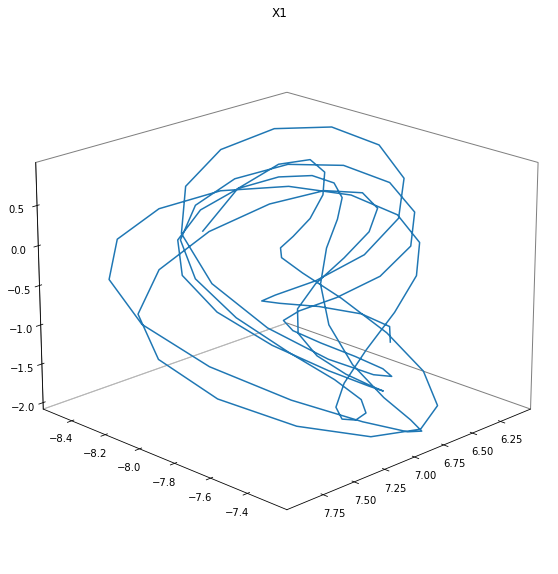

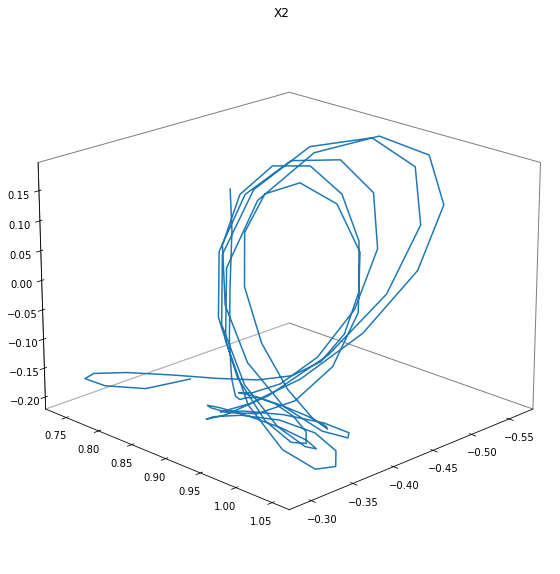

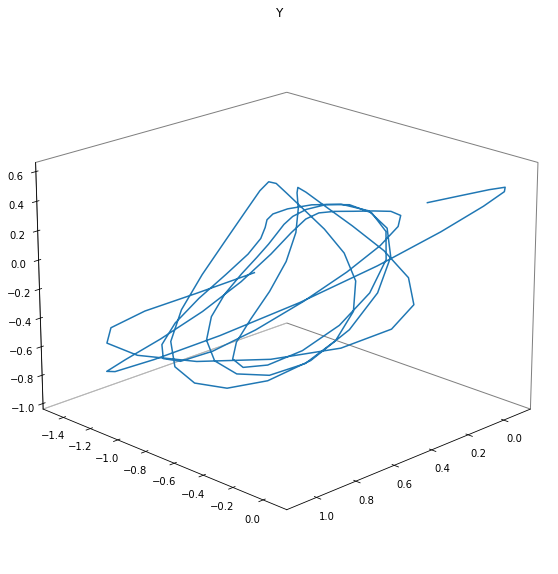

In [24]:
for i,data in [('X1',X1),('X2',X2), ('Y',Y)]:
    with PdfPages(i+'.pdf') as pdf:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(data.iloc[30:150,1],
                data.iloc[30:150,2],
                data.iloc[30:150,3],
                label='parametric curve')
        ax.grid(False)
        ax.set_title(i)
        ax.xaxis.set_rotate_label(False)
        ax.yaxis.set_rotate_label(False)
        ax.zaxis.set_rotate_label(False)
        ax.view_init(elev=20, azim=45)
        ax.xaxis.pane.set_edgecolor('black')
        ax.yaxis.pane.set_edgecolor('black')
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        pdf.savefig()

In [25]:
def HankelMatrix(X, L):  
    N = X.shape[0]
    return scipy.linalg.hankel(X[ : N - L + 1], X[N - L : N])
time = X1.iloc[:,0].values
X1_ = np.concatenate((HankelMatrix(X1.iloc[:,1].values, 25),HankelMatrix(X1.iloc[:,2].values, 25),HankelMatrix(X1.iloc[:,3].values, 25)),axis=1)
X2_ = np.concatenate((HankelMatrix(X2.iloc[:,1].values, 25),HankelMatrix(X2.iloc[:,2].values, 25),HankelMatrix(X2.iloc[:,3].values, 25)),axis=1)
Y_ = np.concatenate((HankelMatrix(Y.iloc[:,1].values, 25),HankelMatrix(Y.iloc[:,2].values, 25),HankelMatrix(Y.iloc[:,3].values, 25)),axis=1)

In [26]:
X_m = np.concatenate((X1_,X2_), axis=1)
X_t = np.concatenate((X1_[...,None],X2_[...,None]), axis=2)
print('Shape of matrix of features:', X_m.shape)
print('Shape of tensor of features:', X_t.shape)

Shape of matrix of features: (298, 150)
Shape of tensor of features: (298, 75, 2)


In [27]:
X_m = (X_m - X_m.mean(axis=0)) / X_m.std(axis=0)
X_t = (X_t - X_t.mean(axis=0)) / X_t.std(axis=0)
Y_ = (Y_ - Y_.mean(axis=0)) / Y_.std(axis=0)
X_m_train, X_m_test = X_m[:200,:], X_m[200:,:]
Y_train, Y_test = Y_[:200,:], Y_[200:,:]
X_t_train, X_t_test = X_t[:200,:,:], X_t[200:,:,:]

# PLS

In [28]:
def get_autoreg_Y(Y, step=1):
    m, t = Y.shape
    ar = np.zeros((m - step + 1, t * step))
    for i in range(step):
        for k in range(t):
            ar[:, i * t + k] = Y[i: m + i - step + 1, k]

    return ar

def get_bootstrap(X, Y):
    n = X.shape[0]
    idxs = np.random.choice(np.arange(n), size=n)
    return X[idxs], Y[idxs]

In [29]:
def RMSE(Y_pred,Y):
    Y_base = Y.mean(axis=0)
    return np.mean(np.sqrt(np.mean((Y - Y_pred) ** 2, axis=0)) / np.sqrt(np.mean((Y - Y_base) ** 2, axis=0)))

def q2_m(y_true,y_pred):
    return 1 - ((np.linalg.norm(y_true - y_pred) ** 2) / (np.linalg.norm(y_true) ** 2))

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.70it/s]


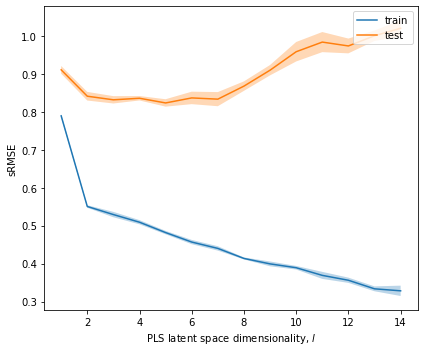

5 components with nRMSE = 0.8235425064412064


In [18]:
step = 30
n_restarts = 5

Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_train, step), get_autoreg_Y(Y_test, step)
Xtrain_ar, Xtest_ar = X_m_train[:X_m_train.shape[0] - step + 1], X_m_test[:X_m_test.shape[0] - step + 1]

rmse = []
for k in tqdm(range(1, 15)):
    pls = PLSRegression(n_components=k)
    tr = []
    te = []
    for i in range(n_restarts):
        X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
        pls.fit(X, Y)
        tr.append(metric_nmse(X, Y, pls))
        te.append(metric_nmse(Xtest_ar, Ytest_ar, pls))
    rmse.append((k, tr, te))
    
x = [r[0] for r in rmse]
y1_mean = np.array([np.mean(r[1]) for r in rmse])
y2_mean = np.array([np.mean(r[2]) for r in rmse])
y1_std = np.array([np.std(r[1]) for r in rmse])
y2_std = np.array([np.std(r[2]) for r in rmse])

plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')
plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

plt.plot(x, y2_mean, label='test')
plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)
plt.ylabel(r'sRMSE')
plt.xlabel(r'PLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('ECoG_PLS.pdf', format='pdf')
plt.show()
    
print(np.argmin(np.array(y2_mean))+1,'components with nRMSE =', min(y2_mean))

In [20]:
from time import time
start = time()
pls = PLSRegression(n_components=np.argmin(np.array(y2_mean))+1)
tr = []
te = []
for i in range(n_restarts):
    X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
    pls.fit(X, Y)
    tr.append(metric_nmse(X, Y, pls))
    te.append(metric_nmse(Xtest_ar, Ytest_ar, pls))
end = time()
PLS_time = end-start
PLS_rmse_test = np.mean(te)
PLS_rmse_train = np.mean(tr)
PLS_rmse_test_std = np.std(te)
PLS_rmse_train_std = np.std(te)
print('Time:', PLS_time)
print('Train rmse:', PLS_rmse_train,'±',PLS_rmse_train_std)
print('Test rmse:', PLS_rmse_test,'±',PLS_rmse_test_std)

Time: 0.25499796867370605
Train rmse: 0.48301736841779574 ± 0.011520159535699888
Test rmse: 0.8224108325387715 ± 0.011520159535699888


# QPFS + PLS

In [25]:
n_samples, n_features = X_m_train.shape
qpfs = QPFS()
mqpfs = MultivariateQPFS()
steps = [21, 24, 27, 30]
n_restarts = 3
modes = ['RelAgg','AsymImp']

for step in steps:
    Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_train, step), get_autoreg_Y(Y_test, step)
    Xtrain_ar, Xtest_ar = X_m_train[:X_m_train.shape[0] - step + 1], X_m_test[:X_m_test.shape[0] - step + 1]
    print('step', step)
    print(Ytrain_ar.shape, Xtrain_ar.shape, Ytest_ar.shape, Xtest_ar.shape)

    qpfs.fit(Xtrain_ar, Ytrain_ar)
    
    score_history = [qpfs.zx]
    
    mqpfs.get_params(Xtrain_ar, Ytrain_ar)
    for mode in modes[1:]:
        alphas = mqpfs.get_alpha(mode)
        mqpfs.solve_problem(alphas, mode)
        score_history.append(mqpfs.zx)
    
    n_active_array = np.arange(1, n_features // 2, 10)
    
    for i in range(n_restarts):
        X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
        results = get_metrics(n_active_array, modes, score_history, 
                              X, Y, Xtest_ar, Ytest_ar)

step 21
(180, 1575) (180, 150) (78, 1575) (78, 150)
step 24
(177, 1800) (177, 150) (75, 1800) (75, 150)
step 27
(174, 2025) (174, 150) (72, 2025) (72, 150)
step 30
(171, 2250) (171, 150) (69, 2250) (69, 150)


In [26]:
from itertools import combinations
lr = LinearRegression()
step = 30
n_restarts = 3

modes = ['RelAgg', 'AsymImp']

Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_train, step), get_autoreg_Y(Y_test, step)
Xtrain_ar, Xtest_ar = X_m_train[:X_m_train.shape[0] - step + 1], X_m_test[:X_m_test.shape[0] - step + 1]

for i in range(1,2):
    print(modes[i])
    sh = [np.array(s)[:n_features] for s in score_history]
    corrs = []
    l2s = []
    l1s = []
    comps = []
    hams = []
    rmse = []
    for s1, s2 in combinations(sh, 2):
        corrs.append(sc.stats.spearmanr(s1, s2)[0])
        l2s.append(np.sqrt(np.sum((s1 - s2) ** 2)))
        l1s.append(np.sum(np.abs(s1 - s2)))
        hams.append(sc.spatial.distance.hamming(s1 > 1e-3, s2 > 1e-3))
        
    for s1 in sh:
        comps.append(np.sum(s1 > 1e-6))
        active_idxs = s1.argsort()[::-1][:100]#[:np.sum(s1 > 1e-3)]
        lr.fit(Xtrain_ar[:, active_idxs], Ytrain_ar)
        rmse.append(metric_rmse(Xtest_ar[:, active_idxs], Ytest_ar, lr))
    mean_corr = np.mean(corrs)
    std_corr = np.std(corrs)
    
    mean_l2 = np.mean(l2s)
    std_l2 = np.std(l2s)
    
    mean_l1 = np.mean(l1s)
    std_l1 = np.std(l1s)
    
    mean_comp = np.mean(comps)
    std_comp = np.std(comps)
    
    mean_ham = np.mean(hams)
    std_ham = np.std(hams)
    
    mean_rmse = np.mean(rmse)
    std_rmse = np.std(rmse)
    
    print(f'corr {mean_corr:.3f} $\pm$ {std_corr:.3f}')
    print(f'l2 {mean_l2:.3f} $\pm$ {std_l2:.3f}')
    print(f'l1 {mean_l1:.3f} $\pm$ {std_l1:.3f}')
    print(f'comp {mean_comp:.1f} $\pm$ {std_comp:.1f}')
    print(f'ham {mean_ham:.3f} $\pm$ {std_ham:.3f}')
    print(f'rmse {mean_rmse:.3f} $\pm$ {std_rmse:.3f}')
    print('-' * 80)

AsymImp
corr 0.812 $\pm$ 0.000
l2 0.035 $\pm$ 0.000
l1 0.352 $\pm$ 0.000
comp 147.0 $\pm$ 3.0
ham 0.053 $\pm$ 0.000
rmse 2.414 $\pm$ 0.529
--------------------------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.54it/s]


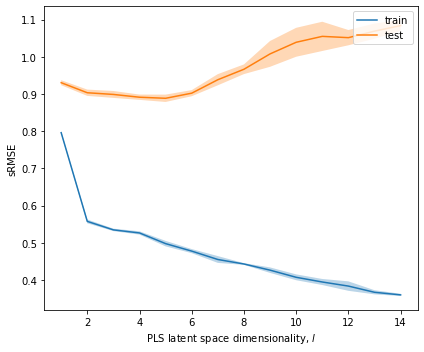

5 components with nRMSE = 0.8883878201637844


In [27]:
n_restarts = 5
step = 30

Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_train, step), get_autoreg_Y(Y_test, step)
Xtrain_ar, Xtest_ar = X_m_train[:X_m_train.shape[0] - step + 1,active_idxs], X_m_test[:X_m_test.shape[0] - step + 1,active_idxs]

rmse = []
for k in tqdm(range(1, 15)):
    pls = PLSRegression(n_components=k)
    tr = []
    te = []
    for i in range(n_restarts):
        X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
        pls.fit(X, Y)
        tr.append(metric_nmse(X, Y, pls))
        te.append(metric_nmse(Xtest_ar, Ytest_ar, pls))
    rmse.append((k, tr, te))
    
x = [r[0] for r in rmse]
y1_mean = np.array([np.mean(r[1]) for r in rmse])
y2_mean = np.array([np.mean(r[2]) for r in rmse])
y1_std = np.array([np.std(r[1]) for r in rmse])
y2_std = np.array([np.std(r[2]) for r in rmse])

plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')
plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

plt.plot(x, y2_mean, label='test')
plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)
plt.ylabel(r'sRMSE')
plt.xlabel(r'PLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('ECoG_QPFS+PLS.pdf', format='pdf')
plt.show()
    
print(np.argmin(np.array(y2_mean))+1,'components with nRMSE =', min(y2_mean))

In [28]:
step = 24
mode = 'AsymImp'
n_samples, n_features = X_m_train.shape
Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_train, step), get_autoreg_Y(Y_test, step)
Xtrain_ar, Xtest_ar = X_m_train[:X_m_train.shape[0] - step + 1], X_m_test[:X_m_test.shape[0] - step + 1]

start = time()

qpfs.fit(Xtrain_ar, Ytrain_ar)

score_history = [qpfs.zx]

mqpfs.get_params(Xtrain_ar, Ytrain_ar)
alphas = mqpfs.get_alpha(mode)
mqpfs.solve_problem(alphas, mode)
score_history.append(mqpfs.zx)

n_active_array = np.arange(1, n_features // 2, 10)

for s1 in sh:
    comps.append(np.sum(s1 > 1e-6))
    active_idxs = s1.argsort()[::-1][:100]

Xtrain_ar, Xtest_ar = X_m_train[:X_m_train.shape[0] - step + 1,active_idxs], X_m_test[:X_m_test.shape[0] - step + 1,active_idxs]
pls = PLSRegression(n_components=np.argmin(np.array(y2_mean))+1)
tr = []
te = []
for i in range(n_restarts):
    X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
    pls.fit(X, Y)
    tr.append(metric_nmse(X, Y, pls))
    te.append(metric_nmse(Xtest_ar, Ytest_ar, pls))
    
end = time()
QPFS_PLS_time = end-start
QPFS_PLS_rmse_test = np.mean(te)
QPFS_PLS_rmse_train = np.mean(tr)
QPFS_PLS_rmse_test_std = np.std(te)
QPFS_PLS_rmse_train_std = np.std(te)
print('Time:', QPFS_PLS_time)
print('Train rmse:', QPFS_PLS_rmse_train,'±',QPFS_PLS_rmse_train_std)
print('Test rmse:', QPFS_PLS_rmse_test,'±',QPFS_PLS_rmse_test_std)

Time: 7.71933388710022
Train rmse: 0.505542443676998 ± 0.015729902252005115
Test rmse: 0.8997618983800171 ± 0.015729902252005115


## HOPLS

In [9]:
from GenerateData import generateComplex
import os
import sys
import warnings
import torch
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold
from scipy.io import loadmat, savemat
from joblib import Parallel, delayed
from hopls import matricize, qsquared, HOPLS
import tensorly as tl

def compute_rmse_pls(tdata, tlabel, vdata, vlabel, Rval):
    test = PLSRegression(n_components=Rval,scale=False,max_iter=1000,tol=1e-5)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        test.fit(matricize(tdata), matricize(tlabel))
    Y_pred = test.predict(matricize(vdata))
    Q2 = qsquared(matricize(vlabel), matricize(Y_pred))
    return Q2

def compute_rmse_hopls(tdata, tlabel, vdata, vlabel, la, R_max=20):
    Ln = [la] * (len(tdata.shape) - 1)
    if len(tlabel.shape) > 2:
        Km = [la] * (len(tlabel.shape) - 1)
    else:
        Km = None
    test = HOPLS(R_max, Ln, Km)
    test.fit(tdata, tlabel)
    label_pred_train, r_train, _ = test.predict(tdata, tlabel)
    label_pred_test, r_test, _ = test.predict(vdata, vlabel)
    rmse_train = RMSE(label_pred_train.numpy(),tlabel.numpy())
    rmse_test = RMSE(label_pred_test.numpy(),vlabel.numpy())
    return rmse_train, rmse_test


In [11]:
RMSE_hopls = []

for R in range(1,61,4):
    for l in range(1,61,4):
        rmse_tr, rmse_te = compute_rmse_hopls(torch.tensor(X_t_train),torch.tensor(Y_train), torch.tensor(X_t_test), torch.tensor(Y_test),l,R)
        RMSE_hopls.append([R,l,rmse_tr,rmse_te])

In [12]:
y2_mean = np.array([r[3] for r in RMSE_hopls])
R = RMSE_hopls[np.argmin(y2_mean)][0]
l = RMSE_hopls[np.argmin(y2_mean)][1]
print('RMSE fo test:', RMSE_hopls[np.argmin(y2_mean)][3])

RMSE fo test: 0.6274715892450335


In [13]:
R, l

(45, 1)

<Figure size 432x360 with 0 Axes>

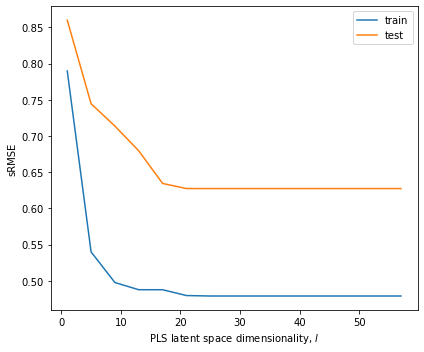

49 components with nRMSE = 0.6274715892450335


In [15]:
plt.figure(figsize=(6, 5))
x = np.array(range(1,61,4))
y1_mean = np.array([np.mean(r[2]) for r in RMSE_hopls])[np.where(np.array([r[1] for r in RMSE_hopls])==1)]
y2_mean = np.array([np.mean(r[3]) for r in RMSE_hopls])[np.where(np.array([r[1] for r in RMSE_hopls])==1)]

plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')

plt.plot(x, y2_mean, label='test')
plt.ylabel(r'sRMSE')
plt.xlabel(r'PLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('ECoG_HOPLS.pdf', format='pdf')
plt.show()
    
print(x[np.argmin(np.array(y2_mean))+1],'components with nRMSE =', min(y2_mean))

In [17]:
from time import time
n_restarts = 5
start = time()
tr = []
te = []
for i in range(n_restarts):
    rmse_tr, rmse_te = compute_rmse_hopls(torch.tensor(X_t_train),torch.tensor(Y_train), torch.tensor(X_t_test), torch.tensor(Y_test),l,R)
    tr.append(rmse_tr)
    te.append(rmse_te)
end = time()
HOPLS_time = end-start
HOPLS_rmse_test = np.mean(te)
HOPLS_rmse_train = np.mean(tr)
HOPLS_rmse_test_std = np.std(te)
HOPLS_rmse_train_std = np.std(te)
print('Time:', HOPLS_time)
print('Train rmse:', HOPLS_rmse_train,'±',HOPLS_rmse_train_std)
print('Test rmse:', HOPLS_rmse_test,'±',HOPLS_rmse_test_std)

Time: 1.9130010604858398
Train rmse: 0.4791115720163129 ± 1.3296282353763972e-14
Test rmse: 0.6274715892450586 ± 1.3296282353763972e-14


## 2D-PCA  then PLS

In [18]:
import numpy as np
import scipy.linalg as s_linalg


class two_d_pca_class:


    def give_p(self, d):
        #print("D", d)
        sum = np.sum(d)
        sum_85 = self.p * sum
        temp = 0
        p = 0
        while temp < sum_85:
            temp += d[p]
            p += 1
        return p

    def reduce_dim(self):

        no_of_images = self.images.shape[0]
        mat_height = self.images.shape[1]
        mat_width = self.images.shape[2]
        g_t = np.zeros((mat_width, mat_width))
        h_t = np.zeros((mat_height, mat_height))

        for i in range(no_of_images):
            temp = np.dot(self.images_mean_subtracted[i].T, self.images_mean_subtracted[i])
            #print(temp.shape,g_t.shape,h_t.shape)
            g_t += temp
            h_t += np.dot(self.images_mean_subtracted[i], self.images_mean_subtracted[i].T)

        g_t /= no_of_images
        h_t /= no_of_images

        #For G_T
        d_mat, p_mat = np.linalg.eig(g_t)
        p_1 = self.give_p(d_mat)
        self.new_bases_gt = p_mat[:, 0:p_1]

        #For H_T
        d_mat, p_mat = np.linalg.eig(h_t)
        p_2 = self.give_p(d_mat)
        self.new_bases_ht = p_mat[:, 0:p_2]


        new_coordinates_temp = np.dot(self.images, self.new_bases_gt)

        self.new_coordinates = np.zeros((no_of_images, p_2, p_1))

        for i in range(no_of_images):
            self.new_coordinates[i, :, :] = np.dot(self.new_bases_ht.T, new_coordinates_temp[i])

        return self.new_coordinates


    def __init__(self, images,p):
        self.images = np.asarray(images)
        self.mean_face = np.mean(self.images, 0)
        self.p = p
        self.images_mean_subtracted = self.images - self.mean_face


    def original_data(self, new_coordinates):
        return np.dot(self.new_bases_ht, np.dot(new_coordinates, self.new_bases_gt.T))


    def new_cord_for_image(self, image):
        new_image = np.zeros((image.shape[0],self.new_bases_ht.shape[1],self.new_bases_gt.shape[1]))
        for i in range(image.shape[0]):
            new_image[i,:,:] = np.dot(self.new_bases_ht.T, np.dot(image[i,:,:], self.new_bases_gt))
        return new_image



In [42]:
n_restarts = 5
rmse = []
for p in np.arange(0.9,1,0.005):
        pca = two_d_pca_class(X_t_train,p)
        X_n_train = pca.reduce_dim().reshape(X_t_train.shape[0],-1)
        X_n_test = pca.new_cord_for_image(X_t_test).reshape(X_t_test.shape[0],-1)
        for k in range(1, 4):
            pls = PLSRegression(n_components=k)
            tr = []
            te = []
            for i in range(n_restarts):
                X, Y = X_n_train, Y_train
                pls.fit(X, Y)
                tr.append(metric_nmse(X, Y, pls))
                te.append(metric_nmse(X_n_test, Y_test, pls))
            rmse.append((k, tr, te, p))

In [43]:
y2_mean = np.array([np.mean(r[2]) for r in rmse])
p = rmse[np.argmin(y2_mean)][3]
print('percentage of information:', round(p*100,2), 'RMSE fo test:', np.mean(rmse[np.argmin(y2_mean)][2]))

percentage of information: 90.5 RMSE fo test: 0.7401976015013912


  7%|█████▉                                                                             | 1/14 [00:00<00:01,  7.81it/s]

(200, 16) (98, 16)


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.09it/s]


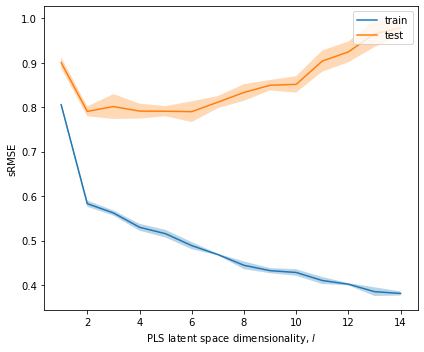

6 components with nRMSE = 0.7900918510481746


In [44]:
pca = two_d_pca_class(X_t_train,rmse[np.argmin(y2_mean)][3])
X_n_train = pca.reduce_dim().reshape(X_t_train.shape[0],-1)
X_n_test = pca.new_cord_for_image(X_t_test).reshape(X_t_test.shape[0],-1)
print(X_n_train.shape,X_n_test.shape)
n_restarts = 5
step = 30

Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_train, step), get_autoreg_Y(Y_test, step)
Xtrain_ar, Xtest_ar = X_n_train[:X_n_train.shape[0] - step + 1,], X_n_test[:X_n_test.shape[0] - step + 1]

rmse = []
for k in tqdm(range(1, 15)):
    pls = PLSRegression(n_components=k)
    tr = []
    te = []
    for i in range(n_restarts):
        X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
        pls.fit(X, Y)
        tr.append(metric_nmse(X, Y, pls))
        te.append(metric_nmse(Xtest_ar, Ytest_ar, pls))
    rmse.append((k, tr, te))
    
x = [r[0] for r in rmse]
y1_mean = np.array([np.mean(r[1]) for r in rmse])
y2_mean = np.array([np.mean(r[2]) for r in rmse])
y1_std = np.array([np.std(r[1]) for r in rmse])
y2_std = np.array([np.std(r[2]) for r in rmse])

plt.figure(figsize=(6, 5))

plt.plot(x, y1_mean, label='train')
plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

plt.plot(x, y2_mean, label='test')
plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)
plt.ylabel(r'sRMSE')
plt.xlabel(r'PLS latent space dimensionality, $l$')

plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('ECoG_MPCA+PLS.pdf', format='pdf')
plt.show()
    
print(np.argmin(np.array(y2_mean))+1,'components with nRMSE =', min(y2_mean))

In [45]:
n_restarts = 5
start = time()
pca = two_d_pca_class(X_t_train,p)
X_n_train = pca.reduce_dim().reshape(X_t_train.shape[0],-1)
X_n_test = pca.new_cord_for_image(X_t_test).reshape(X_t_test.shape[0],-1)
n_restarts = 5
step = 30

Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_train, step), get_autoreg_Y(Y_test, step)
Xtrain_ar, Xtest_ar = X_n_train[:X_n_train.shape[0] - step + 1,], X_n_test[:X_n_test.shape[0] - step + 1]
pls = PLSRegression(n_components=np.argmin(np.array(y2_mean))+1)
tr = []
te = []
for i in range(n_restarts):
    X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
    pls.fit(X, Y)
    tr.append(metric_nmse(X, Y, pls))
    te.append(metric_nmse(Xtest_ar, Ytest_ar, pls))
end = time()
MPCA_PLS_time = end-start
MPCA_PLS_rmse_test = np.mean(te)
MPCA_PLS_rmse_train = np.mean(tr)
MPCA_PLS_rmse_test_std = np.std(te)
MPCA_PLS_rmse_train_std = np.std(te)
print('Time:', MPCA_PLS_time)
print('Train rmse:', MPCA_PLS_rmse_train,'±',MPCA_PLS_rmse_train_std)
print('Test rmse:', MPCA_PLS_rmse_test,'±',MPCA_PLS_rmse_test_std)

Time: 0.2860107421875
Train rmse: 0.4935946971215798 ± 0.01500292067472426
Test rmse: 0.7814158367190469 ± 0.01500292067472426


# 2d-PCA + HOPLS

In [19]:
RMSE_pca_hopls = []
for p in np.arange(0.97,0.999,0.005):
        pca = two_d_pca_class(X_t_train,p)
        X_n_train = pca.reduce_dim()
        X_n_test = pca.new_cord_for_image(X_t_test)
        for R in range(1,75,3):
            for l in range(1,75,3):
                rmse_tr, rmse_te = compute_rmse_hopls(torch.tensor(X_n_train),torch.tensor(Y_train), torch.tensor(X_n_test), torch.tensor(Y_test),l,R)
                #Q_hopls.append([R,l,Q])
                RMSE_pca_hopls.append([p,R,l,rmse_tr, rmse_te])
y2_mean = np.array([r[4] for r in RMSE_pca_hopls])
p = RMSE_pca_hopls[np.argmin(y2_mean)][0]
R = RMSE_pca_hopls[np.argmin(y2_mean)][1]
l = RMSE_pca_hopls[np.argmin(y2_mean)][2]
print('Test rmse:', RMSE_pca_hopls[np.argmin(y2_mean)][4])

Test rmse: 0.595586711481844


In [20]:
n_restarts = 5
start = time()
pca = two_d_pca_class(X_t_train,p)
X_n_train = pca.reduce_dim()
X_n_test = pca.new_cord_for_image(X_t_test)
step = 30

Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_train, step), get_autoreg_Y(Y_test, step)
Xtrain_ar, Xtest_ar = X_n_train[:X_n_train.shape[0] - step + 1,], X_n_test[:X_n_test.shape[0] - step + 1]
tr = []
te = []
for i in range(n_restarts):
    rmse_tr, rmse_te = compute_rmse_hopls(torch.tensor(Xtrain_ar),torch.tensor(Ytrain_ar), torch.tensor(Xtest_ar), torch.tensor(Ytest_ar),l,R)
    tr.append(rmse_tr)
    te.append(rmse_te)
end = time()
MPCA_HOPLS_time = end-start
MPCA_HOPLS_rmse_test = np.mean(te)
MPCA_HOPLS_rmse_train = np.mean(tr)
MPCA_HOPLS_rmse_test_std = np.std(te)
MPCA_HOPLS_rmse_train_std = np.std(te)
print('Time:', MPCA_HOPLS_time)
print('Train rmse:', MPCA_HOPLS_rmse_train,'±',MPCA_HOPLS_rmse_train_std)
print('Test rmse:', MPCA_HOPLS_rmse_test,'±',MPCA_HOPLS_rmse_test_std)

Time: 3.11775279045105
Train rmse: 0.44595251185104773 ± 1.4043333874306804e-16
Test rmse: 0.7601841758843466 ± 1.4043333874306804e-16


In [21]:
R

25